# Notebook for unsupervised learning capstone

In [19]:
import numpy as np
import pandas as pd
import re
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
# from nltk.corpus import gutenberg

In [2]:
"""Consider targeting a few different types of authors:
Don't only consider the reviewers with most
Think about lengthy reviews
Or reviews around the median
Diversity in types of reviews
Similarity across reviewers
"""
# gutenberg.fileids()

In [4]:
conn = sqlite3.connect('../../../amazon-fine-food-reviews/database.sqlite')
c = conn.cursor()
c.execute('PRAGMA table_info(reviews)')
print(c.fetchall())

[(0, 'Id', 'INTEGER', 0, None, 1), (1, 'ProductId', 'TEXT', 0, None, 0), (2, 'UserId', 'TEXT', 0, None, 0), (3, 'ProfileName', 'TEXT', 0, None, 0), (4, 'HelpfulnessNumerator', 'INTEGER', 0, None, 0), (5, 'HelpfulnessDenominator', 'INTEGER', 0, None, 0), (6, 'Score', 'INTEGER', 0, None, 0), (7, 'Time', 'INTEGER', 0, None, 0), (8, 'Summary', 'TEXT', 0, None, 0), (9, 'Text', 'TEXT', 0, None, 0)]


In [5]:
c.execute('SELECT * FROM reviews LIMIT 1;')
c.fetchall()

[(1,
  'B001E4KFG0',
  'A3SGXH7AUHU8GW',
  'delmartian',
  1,
  1,
  5,
  1303862400,
  'Good Quality Dog Food',
  'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.')]

In [7]:
df = pd.read_csv('../../../amazon-fine-food-reviews/Reviews.csv')

In [8]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [9]:
df.UserId.value_counts()

A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
A1TMAVN4CEM8U8    204
A2MUGFV2TDQ47K    201
A3TVZM3ZIXG8YW    199
A3PJZ8TU8FDQ1K    178
AQQLWCMRNDFGI     176
A2SZLNSI5KOQJT    175
A29JUMRL1US6YP    172
AZV26LP92E6WU     167
A31N6KB160O508    162
AY1EF0GOH80EK     162
A2FRFAQCWZJT3Q    161
A1UQBFCERIP7VJ    157
AKMEY1BSHSDG7     155
A1LZJZIHUPLDV4    154
A1WX42M589VAMQ    151
A3D6OI36USYOU1    150
A2Y8IDC1FKGNJC    150
A3HPCRD9RX351S    149
A2PNOU7NXB1JE4    143
AKZKG2Z7CNV27     143
A33AQPJYH7UUXR    142
A35R32TA60XD57    141
A1IU7S4HCK1XK0    140
A1X1CEGHTHMBL1    135
A36WGHR8TO5DKT    134
                 ... 
A1NCEC7LRTXYCF      1
A2I932BW9ULWXD      1
A3PGTAHI2E9YI0      1
A3IXGGZBUM9MFE      1
AZS61QELLOBE2       1
A1Y2GPGPBMWSP1      1
AH2JKQTNPRI7        1
A1KX4M7HTGX8I4      1
AHKP9HDJGI6SC       1
A2X61Y9TV676SB      1
A1JBW3S1UXXKE9      1
A2EUOBF8U575HC      1
A3F9UAX22LLZWK      1
A19LWKJX1BAO4U      1
AG7I2N91NM

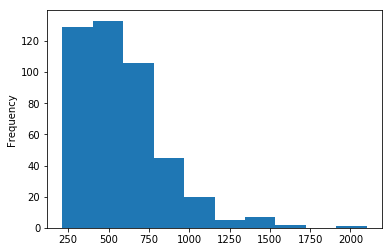

In [22]:
df[df.UserId == 'A3OXHLG6DIBRW8']['Text'].str.len().plot(kind='hist')

In [24]:
len(df[df.UserId == 'A3OXHLG6DIBRW8']['Text'].str.cat())

262696

In [ ]:
for id in df.

In [25]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [28]:
df.iloc[0]['Summary'] in df.iloc[0]['Text']

False